## Imports

In [112]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [113]:
projectdir = "/home/jovyan/work/MED_Fall"
workdir = "/home/jovyan/work"

In [114]:
import os

os.environ["PYTHONPATH"]

'/home/jovyan/work/MED_Fall/'

In [115]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

from vision.pre_processing.extract_frames import FramesExtractor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils.utility_functions import listdir_nohidden_sorted as lsdir
from utils.utility_functions import load_images, show_images

In [116]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setup the dataframe for keras flow_from_dataframe pipeline

In [117]:
extracted_frames_path = (
    "/home/jovyan/work/MED_Fall/vision/vision_dataset/extracted_frames"
)

In [118]:
start = len(extracted_frames_path) + 1
frames_names = lsdir(extracted_frames_path)
frames_names = list(map(lambda x: x[start:], frames_names))
pd.Series(frames_names[:5])

0    actor_1_bed_cam_1_0000.jpg
1    actor_1_bed_cam_1_0001.jpg
2    actor_1_bed_cam_1_0002.jpg
3    actor_1_bed_cam_1_0003.jpg
4    actor_1_bed_cam_1_0004.jpg
dtype: object

In [119]:
print(len(frames_names))

1182300


In [120]:
ground_truth_path = "/home/jovyan/work/MED_Fall/vision/vision_dataset/ground_truth"
len(lsdir(ground_truth_path))

50

In [121]:
dfs = []
for file in lsdir(ground_truth_path):
    df = pd.read_csv(file)
    dfs.append(df)
dataset = pd.concat(dfs, ignore_index=True)

dataset = dataset.iloc[:, 1:]
dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0000
1,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0001
2,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0002
3,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0003
4,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0004
...,...,...,...,...
1182295,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615
1182296,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616
1182297,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617
1182298,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618


In [122]:
dataset["frame_name"] = pd.Series(frames_names)
dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0000.jpg
1,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0001.jpg
2,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0002.jpg
3,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0003.jpg
4,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0004.jpg
...,...,...,...,...
1182295,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615.jpg
1182296,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616.jpg
1182297,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617.jpg
1182298,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618.jpg


### Visualize some frames from the dataset

In [127]:
##removector repositioning

on_air_ds = dataset.loc[dataset["ar_labels"] == "on_air"]
on_air_ds

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206.jpg
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207.jpg
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208.jpg
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209.jpg
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210.jpg
...,...,...,...,...
1182213,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4533.jpg
1182214,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4534.jpg
1182215,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4535.jpg
1182216,crouched_still,lying_down,on_air,actor_4_chair_full_ph_cam_7_4536.jpg


In [130]:
rand_samples = on_air_ds.groupby("macro_labels").sample(n=10)
rand_samples

,micro_labels,macro_labels,ar_labels,frame_name
357093,walking,adl,on_air,actor_1_walk_ph_cam_5_4833.jpg
763152,walking,adl,on_air,actor_2_walk_full_ph_cam_5_0312.jpg
500571,sit_up_from_lying,adl,on_air,actor_2_bed_full_ph_cam_2_0231.jpg
422898,stand_up_from_sit,adl,on_air,actor_1_walk_stick_full_ph_cam_7_1098.jpg
496884,stand_up_from_sit,adl,on_air,actor_2_bed_full_ph_cam_2_2_0381.jpg
307181,sit_up_from_lying,adl,on_air,actor_1_walk_full_ph_cam_1_0161.jpg
717608,walking,adl,on_air,actor_2_walk_cam_3_5648.jpg
492864,sit_up_from_lying,adl,on_air,actor_2_bed_full_ph_cam_1_0204.jpg
1136346,stand_up_from_sit,adl,on_air,actor_4_chair_cam_2_0426.jpg
610923,stand_still,adl,on_air,actor_2_chair_full_ph_cam_2_0183.jpg


In [133]:
rand_samples["macro_labels"]

357093            adl
763152            adl
500571            adl
422898            adl
496884            adl
307181            adl
717608            adl
492864            adl
1136346           adl
610923            adl
122287        falling
910312        falling
243045        falling
446717        falling
479468        falling
699246        falling
930465        falling
152176        falling
839754        falling
601525        falling
134487     lying_down
768992     lying_down
557401     lying_down
375193     lying_down
33387      lying_down
406492     lying_down
1177527    lying_down
491662     lying_down
1181727    lying_down
287144     lying_down
Name: macro_labels, dtype: object

In [134]:
rand_samples["frame_name"]

357093                actor_1_walk_ph_cam_5_4833.jpg
763152           actor_2_walk_full_ph_cam_5_0312.jpg
500571            actor_2_bed_full_ph_cam_2_0231.jpg
422898     actor_1_walk_stick_full_ph_cam_7_1098.jpg
496884          actor_2_bed_full_ph_cam_2_2_0381.jpg
307181           actor_1_walk_full_ph_cam_1_0161.jpg
717608                   actor_2_walk_cam_3_5648.jpg
492864            actor_2_bed_full_ph_cam_1_0204.jpg
1136346                 actor_4_chair_cam_2_0426.jpg
610923          actor_2_chair_full_ph_cam_2_0183.jpg
122287         actor_1_bed_rolling_ph_cam_4_0247.jpg
910312        actor_3_rolling_full_ph_cam_6_0232.jpg
243045          actor_1_walk2_full_ph_cam_4_7545.jpg
446717             actor_2_bed_armour_cam_7_2117.jpg
479468                    actor_2_bed_cam_5_5888.jpg
699246                   actor_2_walk_cam_1_1206.jpg
930465                   actor_3_walk_cam_5_1425.jpg
152176                  actor_1_chair_cam_7_2176.jpg
839754                    actor_3_bed_cam_7_07

(30, 224, 224, 3)


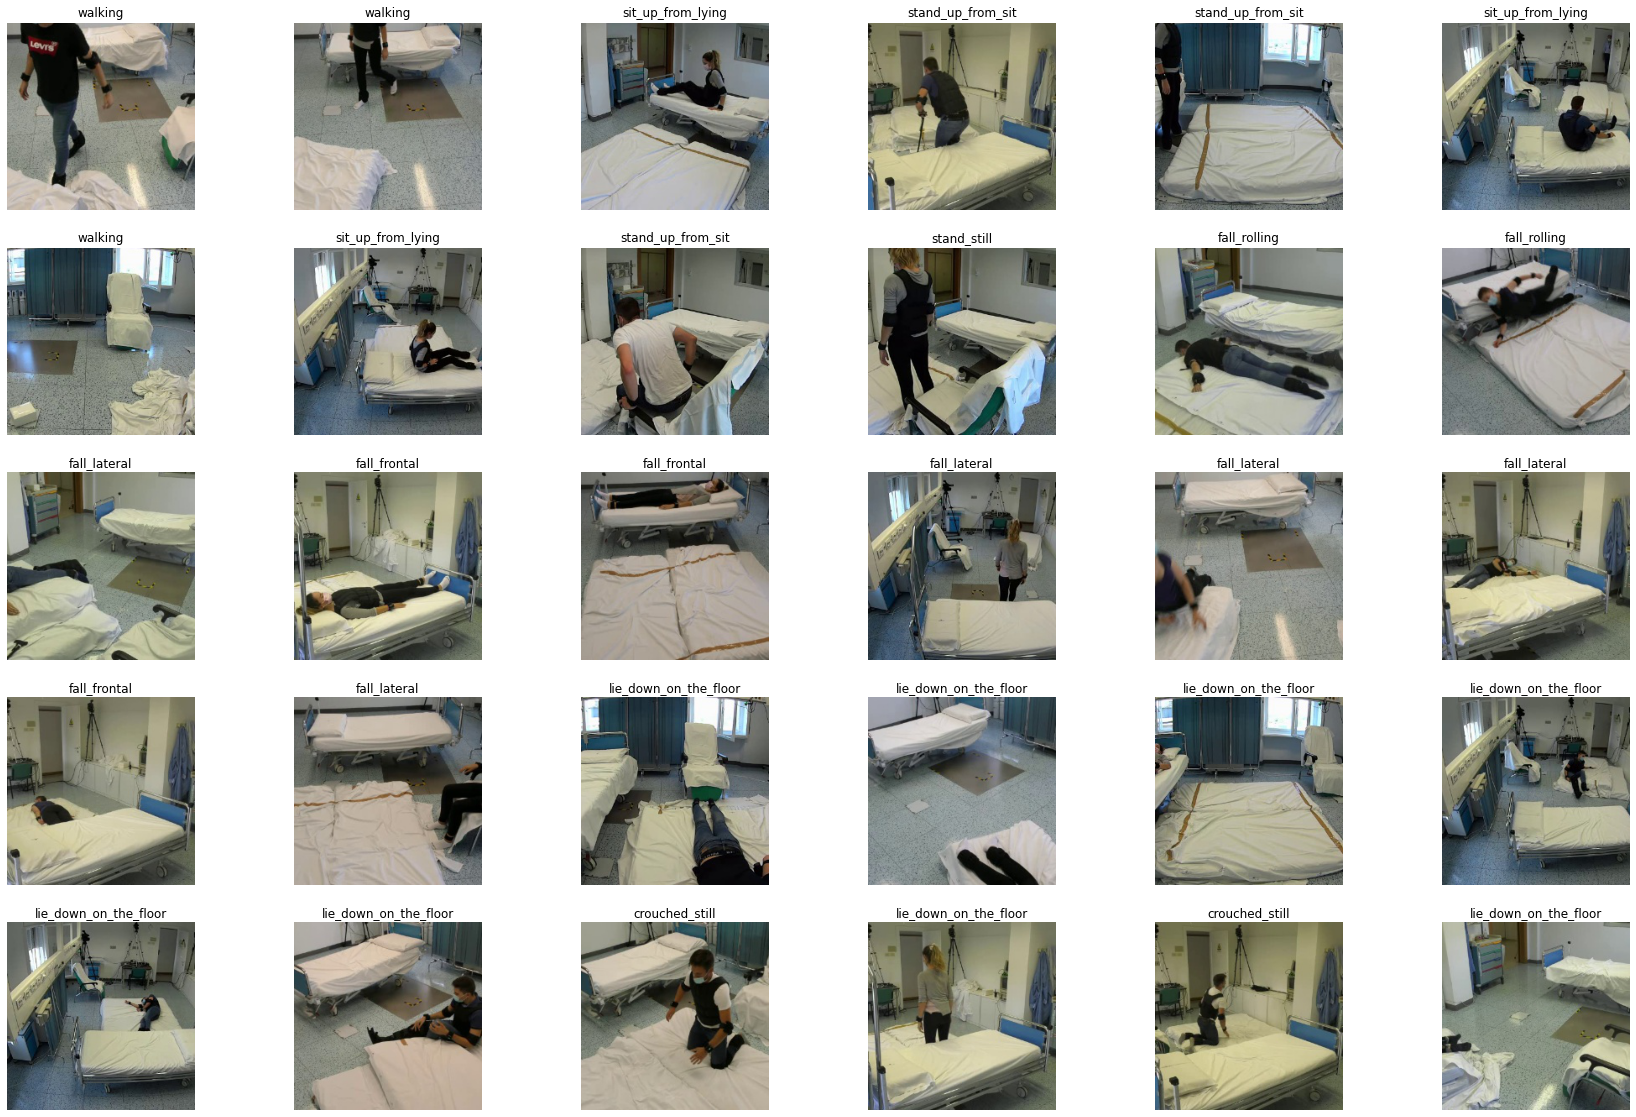

In [135]:
images = load_images(extracted_frames_path, rand_samples["frame_name"])

show_images(images, rows=5, figsize=(30, 20), titles=rand_samples["micro_labels"])

## Subsample dataset choosing Actor 4 as fine tuning data

In [13]:
# select only actor 4
actor_4_dataset = dataset[dataset["frame_name"].str.contains("actor_4")]

In [14]:
actor_4_dataset.reset_index(drop=True, inplace=True)
actor_4_dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0000.jpg
1,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0001.jpg
2,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0002.jpg
3,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0003.jpg
4,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0004.jpg
...,...,...,...,...
168415,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615.jpg
168416,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616.jpg
168417,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617.jpg
168418,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618.jpg


In [15]:
train_set = actor_4_dataset.sample(
    frac=0.9, random_state=2
)  # random state is a seed value
val_set = actor_4_dataset.drop(train_set.index)

print(train_set.shape, val_set.shape)

(151578, 4) (16842, 4)


In [16]:
train_set["macro_labels"].value_counts()

adl           122360
lying_down     20453
falling         8765
Name: macro_labels, dtype: int64

In [17]:
adl_train = train_set.loc[train_set["macro_labels"] == "adl"]
adl_train.reset_index(drop=True, inplace=True)
adl_train

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_down_from_sitting,adl,actor_repositioning,actor_4_bed_cam_3_0445.jpg
1,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_4_7022.jpg
2,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_4_2359.jpg
3,sit_up_from_lying,adl,on_air,actor_4_bed_cam_3_1165.jpg
4,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0131.jpg
...,...,...,...,...
122355,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_4_0746.jpg
122356,lie_down_from_sitting,adl,actor_repositioning,actor_4_bed_full_ph_cam_2_5184.jpg
122357,stand_up_from_sit,adl,on_air,actor_4_bed_full_ph_cam_7_1844.jpg
122358,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_4_0187.jpg


In [18]:
lying_down_n_samples = train_set["macro_labels"].value_counts()[1]
lying_down_n_samples

20453

In [19]:
adl_train_under = adl_train.sample(n=lying_down_n_samples, random_state=2)
adl_train_under

,micro_labels,macro_labels,ar_labels,frame_name
6011,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_6_10947.jpg
103894,sit_down_from_standing,adl,actor_repositioning,actor_4_bed_cam_7_2736.jpg
121657,stand_up_from_floor,adl,actor_repositioning,actor_4_bed_full_ph_cam_6_2001.jpg
92094,stand_still,adl,actor_repositioning,actor_4_bed_cam_2_2620.jpg
75005,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_2451.jpg
...,...,...,...,...
100976,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_1_11451.jpg
3589,rolling_bed,adl,on_air,actor_4_bed_rolling_cam_2_0177.jpg
91959,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_cam_4_1063.jpg
35088,stand_up_from_floor,adl,actor_repositioning,actor_4_bed_full_ph_cam_5_3401.jpg


In [20]:
train_set_copy = train_set.copy()
train_set_copy = train_set_copy[train_set_copy["macro_labels"] != "adl"]
train_set_copy

,micro_labels,macro_labels,ar_labels,frame_name
59896,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_4_5296.jpg
115867,fall_rolling,falling,on_air,actor_4_bed_rolling_cam_4_0967.jpg
20943,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_1623.jpg
90841,fall_lateral,falling,on_air,actor_4_bed_full_ph_cam_7_0961.jpg
128548,crouched_still,lying_down,on_air,actor_4_chair_cam_4_1828.jpg
...,...,...,...,...
25898,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_6578.jpg
24940,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_5620.jpg
12103,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_5_1063.jpg
142975,lie_down_on_the_floor,lying_down,on_air,actor_4_chair_full_ph_cam_2_2275.jpg


In [21]:
train_set_copy["macro_labels"].value_counts()

lying_down    20453
falling        8765
Name: macro_labels, dtype: int64

In [22]:
train_set_copy = pd.concat([train_set_copy, adl_train_under], axis=0)
train_set_copy

,micro_labels,macro_labels,ar_labels,frame_name
59896,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_4_5296.jpg
115867,fall_rolling,falling,on_air,actor_4_bed_rolling_cam_4_0967.jpg
20943,lie_still,lying_down,actor_repositioning,actor_4_bed_full_ph_cam_1_1623.jpg
90841,fall_lateral,falling,on_air,actor_4_bed_full_ph_cam_7_0961.jpg
128548,crouched_still,lying_down,on_air,actor_4_chair_cam_4_1828.jpg
...,...,...,...,...
100976,stand_still,adl,actor_repositioning,actor_4_bed_full_ph_cam_1_11451.jpg
3589,rolling_bed,adl,on_air,actor_4_bed_rolling_cam_2_0177.jpg
91959,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_cam_4_1063.jpg
35088,stand_up_from_floor,adl,actor_repositioning,actor_4_bed_full_ph_cam_5_3401.jpg


## Fine tune VGG16 on Actor 4

### Creating Training and Validation Generators

In [23]:
train_set_copy["macro_labels"].value_counts()

lying_down    20453
adl           20453
falling        8765
Name: macro_labels, dtype: int64

In [24]:
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


train_datagen = train_generator.flow_from_dataframe(
    train_set_copy,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=2,
)

Found 49671 validated image filenames belonging to 3 classes.


In [25]:
val_generator = ImageDataGenerator(rescale=1.0 / 255)

val_datagen = val_generator.flow_from_dataframe(
    val_set,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=2,
)

Found 16842 validated image filenames belonging to 3 classes.


In [26]:
pd.Series(train_datagen.classes).value_counts()

2    20453
0    20453
1     8765
dtype: int64

In [27]:
pd.Series(val_datagen.classes).value_counts()

0    13671
2     2234
1      937
dtype: int64

### Download pre-trained VGG16

In [28]:
IMG_SIZE = (224, 224, 3)

In [29]:
feature_extractor = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMG_SIZE,
    pooling="avg",
)

feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2022-08-01 09:01:41.953220: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 09:01:42.366248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13992 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


### Freeze all layers except last convolutional block

In [30]:
# freeze all layers except last five
for layer in feature_extractor.layers[:-9]:
    layer.trainable = False

for i, layer in enumerate(feature_extractor.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d True


### Add top layer to fine tune

In [31]:
x = feature_extractor.output
x = Flatten()(x)
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=3, activation="softmax")(x)

transfer_model = Model(inputs=feature_extractor.input, outputs=x)

transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Compile the model and define callbacks

In [32]:
transfer_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tf.keras.metrics.Recall(class_id=2)],
)

In [33]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{projectdir}/vision/model_checkpoints/resample/vgg_top_fine_tuned_best_epoch_undersample.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

In [34]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(patience=20),
    model_checkpoint,
]

### Train the model

In [ ]:
history = transfer_model.fit(train_datagen, validation_data = val_datagen, epochs=100, callbacks=callbacks)

2022-08-01 09:01:43.175124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-01 09:01:44.579877: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-08-01 09:01:47.325915: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1553/1553 [==============================] - 418s 266ms/step - loss: 0.7981 - accuracy: 0.6200 - recall: 0.6003 - val_loss: 0.4988 - val_accuracy: 0.7777 - val_recall: 0.8021

Epoch 00001: val_loss improved from inf to 0.49879, saving model to /home/jovyan/work/MED_Fall/vision/model_checkpoints/resample/vgg_top_fine_tuned_best_epoch_undersample.h5
Epoch 2/100
1553/1553 [==============================] - 411s 265ms/step - loss: 0.5417 - accuracy: 0.7687 - recall: 0.8777 - val_loss: 0.5175 - val_accuracy: 0.7744 - val_recall: 0.9731

Epoch 00002: val_loss did not improve from 0.49879
Epoch 3/100
 763/1553 [=============>................] - ETA: 3:14 - loss: 0.4663 - accuracy: 0.8048 - recall: 0.9091

In [ ]:
#%cp /home/jovyan/work/MED_Fall/vision/model_checkpoints/vgg_top_fine_tuned_best_epoch.h5 /home/jovyan/work/persistent/

### Evaluate the model

In [ ]:
transfer_model.evaluate(val_datagen)

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
y_preds_logits = transfer_model.predict(val_datagen)

In [ ]:
y_preds = np.argmax(y_preds_logits, axis=-1)

In [ ]:
print(classification_report(y_true=val_datagen.classes, y_pred=y_preds))

In [ ]:
pd.Series(train_datagen.classes).value_counts()